In [1]:
# Import libraries and functions
from __future__ import print_function
import numpy as np
np.random.seed(1337)  # for reproducibility

import csv
import os,random

from keras.models import Sequential
from keras.layers import Dense
from keras.layers.convolutional import Convolution1D
from keras.layers.core import Dropout, Activation, Flatten
from keras.layers.advanced_activations import LeakyReLU
from keras.layers import LSTM, SimpleRNN, Bidirectional
from keras.optimizers import *
from keras.callbacks import EarlyStopping
from keras import metrics

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.metrics import mean_squared_error
from math import sqrt
from scipy.io import loadmat

Using TensorFlow backend.


In [2]:
timesteps = 240, # timestep
nr = 90   # repetition number
n_dim = 117  # Dimension of data sequences
dropout_rate = 0.2   # Droput rate

In [3]:
x = loadmat('../Dimensionality-Reduction/Data/M1-DeepSquat.mat')
correct = x['Train_Data']
T1 = correct.shape[1]
incorrect = x['Test_Data']
T2 = incorrect.shape[1]
Correct_label = np.loadtxt('../Scoring/Data/Score_Train.csv', delimiter = ',')
Incorrect_label = np.loadtxt('../Scoring/Data/Score_Test.csv', delimiter = ',')
Correct_label = np.reshape(Correct_label,(90,1))
Incorrect_label = np.reshape(Incorrect_label,(90,1))

In [4]:
Train_Data = []
Test_Data = []
for i in range(T1):
    Train_Data.append(correct[0,i])
for i in range(T2):
    Test_Data.append(incorrect[0,i])
Train_Data = np.dstack(Train_Data)
Correct_data = np.rollaxis(Train_Data,-1)
Test_Data = np.dstack(Test_Data)
Incorrect_data = np.rollaxis(Test_Data,-1)

In [5]:
# Print the size of the data 
print(Correct_data.shape, 'correct sequences')
print(Correct_label.shape, 'correct labels')
print(Incorrect_data.shape, 'incorrect sequences')
print(Incorrect_label.shape, 'incorrect labels')


(90, 240, 117) correct sequences
(90, 1) correct labels
(90, 240, 117) incorrect sequences
(90, 1) incorrect labels


In [6]:
# Split the data into training and validation sets
# Training set: 70%
# Validation set: 30%

# First load the shuffled indices
f = open('Shuffled_Indices.csv')
csv_f = csv.reader(f)
indcs = list(csv_f)

# Extract the training and validation indices
trainidx1 = np.squeeze(np.asarray(indcs[:int(nr*0.7)], dtype = np.float64))
trainidx1 = np.asarray(trainidx1, dtype = np.int32)   # convert input to an array
valididx1 = np.squeeze(np.asarray(indcs[int(nr*0.7):nr], dtype = np.float64))
valididx1 = np.asarray(valididx1, dtype = np.int32)
trainidx2 = np.squeeze(np.asarray(indcs[nr:nr+int(nr*0.7)], dtype = np.float64))
trainidx2 = np.asarray(trainidx2, dtype = np.int32)
valididx2 = np.squeeze(np.asarray(indcs[nr+int(nr*0.7):], dtype = np.float64))
valididx2 = np.asarray(valididx2, dtype = np.int32)

# Training set: data and labels
train_x = np.concatenate((Correct_data[trainidx1,:,:],Incorrect_data[trainidx2,:,:]))
print(train_x.shape, 'training data')
train_y = np.concatenate((np.squeeze(Correct_label[trainidx1]),np.squeeze(Incorrect_label[trainidx2])))
print(train_y.shape, 'training labels')

# Validation set: data and labels
valid_x = np.concatenate((Correct_data[valididx1,:,:],Incorrect_data[valididx2,:,:]))
print(valid_x.shape, 'validation data')
valid_y = np.concatenate((np.squeeze(Correct_label[valididx1]),np.squeeze(Incorrect_label[valididx2])))
print(valid_y.shape, 'validation labels')


(124, 240, 117) training data
(124,) training labels
(56, 240, 117) validation data
(56,) validation labels


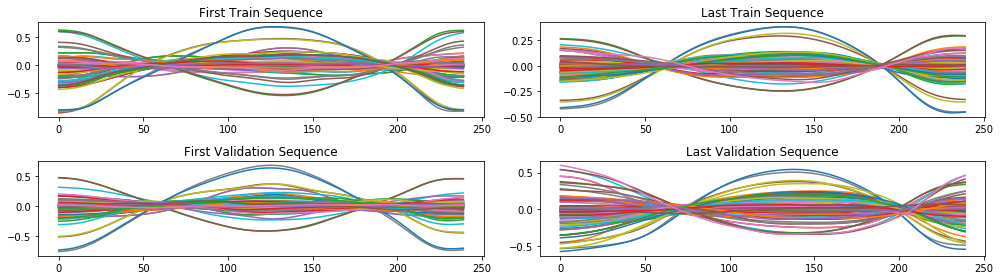

In [7]:
# Plot the first and last sequence in the training and validation data
%matplotlib inline
plt.figure(figsize = (14,4))
plt.subplot(2,2,1)
plt.plot(train_x[0])
plt.title('First Train Sequence')
plt.subplot(2,2,2)
plt.plot(train_x[-1])
plt.title('Last Train Sequence')
plt.subplot(2,2,3)
plt.plot(valid_x[0])
plt.title('First Validation Sequence')
plt.subplot(2,2,4)
plt.plot(valid_x[-1])
plt.title('Last Validation Sequence')
plt.tight_layout()
plt.show()

In [8]:
# Build CNN model ...
def Network():
    
    model = Sequential()
        
    model.add(Convolution1D(180, 5, padding ='same', strides = 2, input_shape = (240,117)))
    model.add(LeakyReLU())
    model.add(Dropout(dropout_rate))
    
    model.add(Convolution1D(120, 5, padding ='same', strides = 2))
    model.add(LeakyReLU())
    model.add(Dropout(dropout_rate))
    
    model.add(Convolution1D(60, 5, padding ='same', strides = 2))
    model.add(LeakyReLU())
    model.add(Dropout(dropout_rate))

    model.add(Convolution1D(30, 3, padding ='same', strides = 2))
    model.add(LeakyReLU())
    model.add(Dropout(dropout_rate))

    model.add(Convolution1D(10, 3, padding ='same'))
    model.add(LeakyReLU())
    model.add(Dropout(dropout_rate))
    
    model.add(Convolution1D(5, 3, padding ='same'))
    model.add(LeakyReLU())
    model.add(Dropout(dropout_rate))
    
    model.add(Bidirectional(LSTM(20, recurrent_dropout = 0.5, return_sequences = True)))
    model.add(Dropout(0.25))
    
    model.add(Flatten())

    model.add(Dense(200))
    model.add(LeakyReLU())
    model.add(Dropout(dropout_rate))

    model.add(Dense(100))
    model.add(LeakyReLU())
    model.add(Dropout(dropout_rate))
    
    model.add(Dense(1))
    model.add(Activation('sigmoid'))

    print(model.summary())
    
    model.compile(loss='binary_crossentropy', optimizer=Adam())
    
    # Request to stop before reaching the number of epochs if the Validaton Loss does not decrease for 100 epochs
    early_stopping = EarlyStopping(monitor='val_loss', patience = 100)

   
    history = model.fit(train_x, train_y, batch_size=5, epochs=5000, verbose=1, 
                     validation_data=(valid_x, valid_y),
                     callbacks = [early_stopping])

    
    # Plot the results
    plt.figure(1)
    plt.subplot(221)
    plt.plot(history.history['loss'])
    plt.title('Training Loss')
    plt.subplot(222)
    plt.plot(history.history['val_loss'])
    plt.title('Validation Loss')
    plt.tight_layout()
    plt.show()
    
    # Plot the prediction of the CNN model for the training and validation sets
    pred_train = model.predict(train_x)
    pred_test = model.predict(valid_x)

    plt.figure(figsize = (14,4))
    plt.subplot(1,2,1)
    plt.plot(pred_train,'bo',label = "Prediction")
    plt.plot(train_y,'g*',label = "Quality Score")
    plt.ylim([-0.1,1.1])
    plt.title('Labels for the training set')
    plt.subplot(1,2,2)
    plt.plot(pred_test,'bo',valid_y,'g*')
    plt.title('Labels for the testing set')
    plt.ylim([-0.1,1.1])
    plt.tight_layout()
    plt.show()
    
    # Calculate the cumulative deviation and rms deviation for the validation set
    test_dev = abs(np.squeeze(pred_test)-valid_y)
    # Cumulative deviation
    mean_abs_dev = np.mean(test_dev)
    # RMS deviation
    rms_dev = sqrt(mean_squared_error(pred_test, valid_y))
    print('Mean absolute deviation:', mean_abs_dev)
    print('RMS deviation:', rms_dev)
    
    return mean_abs_dev, rms_dev


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 120, 180)          105480    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 120, 180)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 120, 180)          0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 60, 120)           108120    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 60, 120)           0         
_________________________________________________________________
dropout_2 (Dropout)  

Epoch 30/5000
124/124 [==============================] - 1s 5ms/step - loss: 0.4038 - val_loss: 0.4056
Epoch 31/5000
124/124 [==============================] - 1s 5ms/step - loss: 0.4032 - val_loss: 0.4056
Epoch 32/5000
124/124 [==============================] - 1s 5ms/step - loss: 0.4031 - val_loss: 0.4040
Epoch 33/5000
124/124 [==============================] - 1s 5ms/step - loss: 0.4030 - val_loss: 0.4042
Epoch 34/5000
124/124 [==============================] - 1s 5ms/step - loss: 0.4034 - val_loss: 0.4079
Epoch 35/5000
124/124 [==============================] - 1s 5ms/step - loss: 0.4037 - val_loss: 0.4039
Epoch 36/5000
124/124 [==============================] - 1s 5ms/step - loss: 0.4030 - val_loss: 0.4040
Epoch 37/5000
124/124 [==============================] - 1s 5ms/step - loss: 0.4027 - val_loss: 0.4048
Epoch 38/5000
124/124 [==============================] - 1s 5ms/step - loss: 0.4036 - val_loss: 0.4059
Epoch 39/5000
124/124 [==============================] - 1s 5ms/step - lo

124/124 [==============================] - 1s 5ms/step - loss: 0.4023 - val_loss: 0.4059
Epoch 110/5000
124/124 [==============================] - 1s 5ms/step - loss: 0.4024 - val_loss: 0.4074
Epoch 111/5000
124/124 [==============================] - 1s 5ms/step - loss: 0.4024 - val_loss: 0.4060
Epoch 112/5000
124/124 [==============================] - 1s 5ms/step - loss: 0.4022 - val_loss: 0.4049
Epoch 113/5000
124/124 [==============================] - 1s 5ms/step - loss: 0.4021 - val_loss: 0.4077
Epoch 114/5000
124/124 [==============================] - 1s 5ms/step - loss: 0.4023 - val_loss: 0.4059
Epoch 115/5000
124/124 [==============================] - 1s 5ms/step - loss: 0.4028 - val_loss: 0.4035
Epoch 116/5000
124/124 [==============================] - 1s 5ms/step - loss: 0.4024 - val_loss: 0.4084
Epoch 117/5000
124/124 [==============================] - 1s 5ms/step - loss: 0.4026 - val_loss: 0.4035
Epoch 118/5000
124/124 [==============================] - 1s 5ms/step - loss: 0

Epoch 188/5000
124/124 [==============================] - 1s 7ms/step - loss: 0.4025 - val_loss: 0.4056
Epoch 189/5000
124/124 [==============================] - 1s 6ms/step - loss: 0.4024 - val_loss: 0.4080
Epoch 190/5000
124/124 [==============================] - 1s 8ms/step - loss: 0.4026 - val_loss: 0.4043
Epoch 191/5000
124/124 [==============================] - 1s 6ms/step - loss: 0.4033 - val_loss: 0.4039


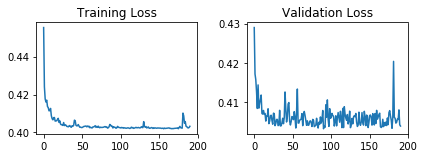

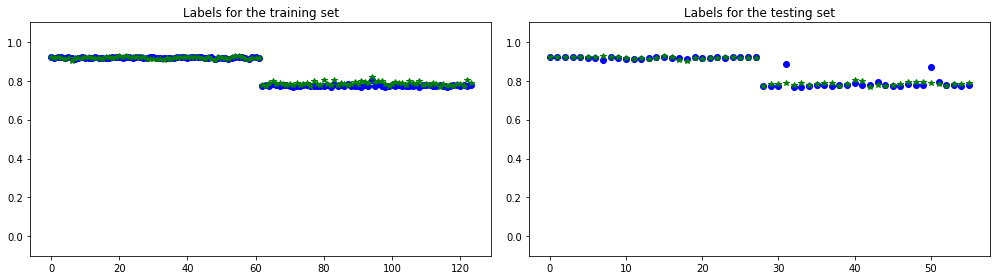

Mean absolute deviation: 0.010032946633928109
RMS deviation: 0.019107542421795548


In [9]:
# call the CNN model   
Mean_abs_dev, RMS_dev  = Network() 